In [ ]:
#hide
from fastdot import *
from fastcore.all import *

# fastdot

> A simple wrapper over `pydot` to make it more consistent, unsurprising, and pythonic

## Install

`pip install fastdot`

## fastdot overview

`fastdot` is a thin wrapper over the excellent [pydot](https://github.com/pydot/pydot) program (which is in turn a thin wrapper over the absolutely wonderful [Graphviz software](https://www.graphviz.org/)), designed to make it more consistent, unsurprising, and pythonic. An example of removing *surprise*: `pydot.Node('node')` gives an obscure compilation exception, since `node` is a keyword in the underlying `graphviz` program, whereas `fastdot.Node('node')` works just fine, due to auto-quoting.

In face, you never need to provide names in `fastdot`, and edges can be created directly between objects:

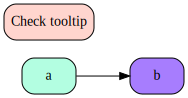

In [ ]:
g = Dot()
a,b = g.add_items('a', 'b')
g.add_item(a.connect(b))
g.add_item(Node('Check tooltip', tooltip="I have a tooltip!"))
g

As you see, graphs know how to show themselves in Jupyter notebooks directly and can be exported to HTML (it uses SVG behind the scenes). Tooltips appear in both notebooks and exported HTML pages. Also, as shown above, you can just use `add_item` or `add_items`, regardless of the type of item.

## Symbolic graphs

`fastdot` is particularly designed to make it easier to create graphs symbolically - for instance, for Python dictionaries, PyTorch/TensorFlow models, and so forth. Here's a simple example with some mock neural network layers and sequential models. First, let's define our mock classes:

In [ ]:
@dataclass(frozen=True)
class Layer:
    name:str; n_filters:int=1

class Linear(Layer): pass
class Conv2d(Layer): pass

@dataclass(frozen=True)
class Sequential:
    layers:list; name:str
    def __hash__(self): return id(self)
    def __repr__(self): return self.name

Here's our sequential blocks for our "model":

In [ ]:
block1 = Sequential([Conv2d('conv', 5), Linear('lin', 3)], 'block1')
block2 = Sequential([Conv2d('conv1', 8), Conv2d('conv2', 2), Linear('lin')], 'block2')

`fastdot` can create all node properties directly from objects; you just have to define functions describing how to map the object's attributes to graph properties. These mappings go in the `node_defaults` and `cluster_defaults` dictionaries (although by default labels are set using `str()`, so we don't need any special cluster defaults in this case):

In [ ]:
node_defaults['fillcolor'] = lambda o: 'greenyellow' if isinstance(o,Linear) else 'pink'
node_defaults['label'] = attrgetter('name')
node_defaults['tooltip'] = str

With that in place, we can directly create nodes from our objects, for instance using the convenient `seq_cluster` function:

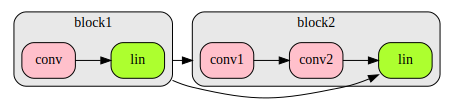

In [ ]:
c1 = seq_cluster(block1.layers, block1)
c2 = seq_cluster(block2.layers, block2)
e1,e2 = c1.connect(c2),c1.connect(c2.last())
graph_items(c1,c2,e1,e2)

## Using object graphs

In the above example, we defined our edges directly between `fastdot` objects. In practice, however, you'll most likely have your edges defined directly between python objects, for instance like this:

In [ ]:
conns = (
    (block1, block2),
    (block1, block2.layers[-1]),
)

In this case, you'll want some way to connect your python objects to the `fastdot` graph items that represent them. A mapping is stored automatically by `fastdot`, and is made available through the `object2graph` function:

In [ ]:
g = Dot()
g.add_items(seq_cluster(block1.layers, block1),
            seq_cluster(block2.layers, block2))

object2graph(block1.layers[-1])

You can use this to graph your connections without needing access to the graph items:

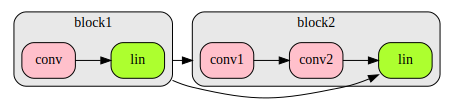

In [ ]:
g.add_items(*[object2graph(a).connect(object2graph(b)) for a,b in conns])
g